In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from os import listdir
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 7,
                     'axes.labelpad': 5,
                     'axes.labelsize': 8,
                     'xtick.labelsize' : 7,
                     'ytick.labelsize' : 7,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 0.5,
                     'lines.markersize': 2,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 80.0,
                     'figure.figsize': [5, 3],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 2,
                     'xtick.minor.size': 1,
                     'ytick.major.size': 2,
                     'ytick.minor.size': 1,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.2,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.2})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "43 wt.% PEI"
SAMPLE_SHORT = SAMPLE[:2]
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[0, 1, 0, 1],
     [0, 1, 0, 1],
     [0, 1, 0, 1, 0]]
# ignore these runs: unusable / redundant data
id_out = ["30-2"]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[5.0588e+02, 5174.770, 9492.830, 14695.640],
             [0, 5.9944e+03, 1.1229e+04, 1.8612e+04],
             [0, 709+8460, 6469+8460, 6867+8460, 12698+8460]]
DT = [[0], [0, 18900, 19080], [0, 8460]]
# columns (indices) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_col, er_col, ei_col, t_col = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI43/"
FILES = [["12-18_M2_TBD039_PEI43_70C_NCNC.TXT"],
         ["12-19_M3_TBD039_PEI43_50C_NCN.TXT", "12-19_M4_TBD039_PEI43_50C_C_zwischensweep.TXT", "12-19_M5_TBD039_PEI43_50C_C.TXT"],
         ["12-20_M3_TBD039_PEI43_30C_N-20min.TXT", "12-20_M4_TBD039_PEI43_30C_20min-nCCN.TXT"]]
DATA = [[],[],[]]

for m, files in enumerate(FILES) :
    for i, file in enumerate(files) :
        data_ = np.genfromtxt(folder+file, delimiter='\t', skip_header=4)
        data_[:,-1] = (data_[:,-1] + DT[m][i])
        if not i :
            after = data_[:,-1] >= GASCHANGE[m][0]
            data = data_[after]
        else :
            data = np.append(data[:], data_[:], axis=0)

     # add final time to GASCHANGE, needed in main and make time unit hours
    GASCHANGE[m].append(data[-1,-1])
    GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
    data[:,-1] = data[:,-1] / 60.
    DATA[m] = data

In [3]:
### Data processing

def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # returns matrix of shape (m-1,n)
    return (y[1:, :] - y[:-1, :]) / (x[1:] - x[:-1])[:, np.newaxis]
    

f_out = [5e5] # ignore data of these frequencies
def extract_interpolate_and_derivative(data, num_points=0):
    """
    Extracts lists x_k for every measured data x at a fixed frequency k
    Creates a universal test set of time points
    Interpolates every fixed-frequency data set for those time points
    Computes derivative epsilon'_der along frequency axis
    """
    
    # Extract unique F_k values
    # ignore frequencies specified in f_out
    unique_f = np.unique(data[:, f_col])
    mask = ~np.isin(unique_f, f_out)
    unique_f = unique_f[mask]
    lnw = np.log(2*np.pi*unique_f)  # Compute ln(omega)
    
    # find time boundaries of data
    # and generate `num_points` equidistant t_i values
    initial_test_t, final_test_t = -np.inf, np.inf
    for f_k in unique_f :
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        initial_test_t = max(initial_test_t, np.min(t_k))
        final_test_t = min(final_test_t, np.max(t_k))
    if not num_points:
        num_points = int((final_test_t - initial_test_t) *2)
        
    t_test_set = np.linspace(initial_test_t, final_test_t, num_points)

    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_int, ei_int = [], []
    # Group er_k and ei_k based on unique F_k
    # unify to test times by interpolation
    for f_k in unique_f:
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        er_k = data[mask][:, er_col]
        ei_k = data[mask][:, ei_col]
        
        interpolator_er_k = interp1d(t_k, er_k, kind='linear', bounds_error=False, fill_value=np.nan)
        interpolator_ei_k = interp1d(t_k, ei_k, kind='linear', bounds_error=False, fill_value=np.nan)

        er_int.append(interpolator_er_k(t_test_set))
        ei_int.append(interpolator_ei_k(t_test_set))

    er_int = np.array(er_int)
    ei_int = np.array(ei_int)


    # Compute gradient of er_k along ln(F)
    er_der =  -np.pi/2 * gradient_matrix(er_int, lnw)
    #er_der =  -np.pi/2 * np.gradient(er_int, lnw, axis=0)

    return unique_f, er_der.T, ei_int.T, t_test_set


def score(popt, pcov, y_data, f_data):
    """
    Computes a fit quality score based on R^2, reduced chi-square, AIC, BIC, and parameter covariances.

    Parameters:
        popt (np.ndarray): Optimized fit parameters from curve_fit.
        pcov (np.ndarray): Covariance matrix of fit parameters from curve_fit.
        y_data (np.ndarray): Measured values.
        f_data (np.ndarray): Fitted values.

    Returns:
        float: Fit quality score (higher is better).
    """
    N = len(y_data)  # Number of data points
    p = len(popt)    # Number of fit parameters
    dof = max(N - p, 1)  # Degrees of freedom (avoid division by zero)

    # Residuals
    residuals = y_data - f_data
    RSS = np.sum(residuals**2)  # Residual sum of squares
    TSS = np.sum((y_data - np.mean(y_data))**2)  # Total sum of squares

    # Coefficient of determination (R^2)
    r_squared = 1 - (RSS / TSS) if TSS > 0 else 0

    # Reduced chi-square (if assuming equal variance in y)
    chi_sq_red = RSS / dof

    # Akaike Information Criterion (AIC)
    aic = 2 * p + N * np.log(RSS / N)

    # Bayesian Information Criterion (BIC)
    bic = p * np.log(N) + N * np.log(RSS / N)

    # Covariance penalty: Large covariance values indicate poorly constrained parameters
    cov_trace = np.trace(pcov) if pcov is not None else 0
    cov_score = np.exp(-np.abs(cov_trace))  # Penalizes large uncertainties

    # Normalize scores
    chi_sq_score = np.exp(-abs(chi_sq_red - 1.0))  # Peaks at chi_sq_red ≈ 1
    aic_bic_score = np.exp(-0.1 * (aic + bic) / 2)  # Penalizes high values

    # Weighted sum (adjust weights if needed)
    score = (0.5 * r_squared) + (0.3 * chi_sq_score) + (0.1 * aic_bic_score) + (0.1 * cov_score)

    return score


In [4]:
### Specify fit function, boundaries and starting initial values; here: CC + CC + CC
# don't forget to change the individual terms in the plot function if fitfunction is edited

# base Cole/Cole function for imaginary part
def CC_I(w, de, a, wp) :
    den = 1 + (1j * w/wp)**a
    return -np.imag(de/den)

#base Cole/Cole function for derivative of real part
def CC_R(w, de, a, wp) :
    A = a*np.pi/2
    W = (w/wp)**a
    return np.pi/2 * a*de*W * np.cos(A - 2* np.arctan(np.sin(A)/(1/W+np.cos(A))) ) / (1 + 2*W*np.cos(A) + W**2)

p_labels = ["$\\Delta\\epsilon$", "$\\alpha$", "$\\omega_p$ [Hz]", 
            "$\\Delta\\epsilon_2$", "$\\alpha_2$", "$\\omega_{p2}$ [Hz]"]

# starting initial guess for every run
p0_start = np.array([
    # 70
    [2, 0.7, 5, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 5, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    # 50
    [2, 0.7, 0.01, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.01, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    # 30
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5],
    [2, 0.7, 0.1, 0.1, 0.5, 4e5]])

# boundaries
i_ = np.inf
wi1, wf1 = 0.0, 1.0
wi2, wf2 = 1.0, 4e4
wi3, wf3 = 4e4, 1e7
bounds = ([0.0, 0.0, wi1, 0.0, 0.0, wi3], [i_, 1.0, wf2, i_, 1.0, wf3])

# functions
def der_real (lnw, de, a, wp, de_2, a_2, wp_2) :
    w = np.exp(lnw)
    return np.log( CC_R(w, de, a, wp) + CC_R(w, de_2, a_2, wp_2) )

def imag (lnw, de, a, wp, de_2, a_2, wp_2) :
    w = np.exp(lnw)
    return np.log ( CC_I(w, de, a, wp) + CC_I(w, de_2, a_2, wp_2) )

def combined_fit(x_all, de, a, wp, de_2, a_2, wp_2):
    x, mask = x_all  # Unpack the concatenated x values and mask
    y_fit = np.where(mask == 0,   # Apply f1 where mask=0, f2 where mask=1
            der_real(x, de, a, wp, de_2, a_2, wp_2), 
            imag(x, de, a, wp, de_2, a_2, wp_2))
    return y_fit

# plot single terms
def plot_parts(ax1, w_, *popt) :
    x1_ = CC_R(w_, *popt[:3])
    x2_ = CC_R(w_, *popt[3:])
    ax1.plot(w_, x1_, linestyle=':', color='red')
    ax1.plot(w_, x2_, linestyle=':', color='blue')

In [5]:
### fitting and plotting procedure

# indices of fit parameter omega, used in "fixorder" to make sure the three terms go from low to high frequency
peak_indices = [2, 5, 8]
def fixorder(p) :
    # fix order of parameters such that peaks are in ascending order
    # old function that might be useful, needs some work
    peaks = p[peak_indices]
    bigger_than_next = peaks[:-1] > peaks[1:]
    while np.any(bigger_than_next) :
        for i, cell in enumerate(bigger_than_next) :
            if cell :
                temp_ = p[i*3:i*3+3]
                p[i*3:i*3+3] = p[i*3+3:i*3+6]
                p[i*3+3:i*3+6] = temp_

                peaks = p[peak_indices]
                bigger_than_next = peaks[:-1] > peaks[1:]
                break
    return p
    

lnw_area = np.linspace(np.log(1.), np.log(6e4), 100)

def fit(x1, y1, x2, y2, p0, run_num) :
    # if the fit didn't converge or receives a bad "score" (see above), 
    # it will retry with the starting initial guess for the current run
    # starting guesses are specified above

    fitf = combined_fit

    # Combine x and y values into a single array (respectively) and create a mask
    x_all = np.concatenate([x1, x2])  # Flatten xdata
    y_all = np.concatenate([y1, y2])
    mask = np.concatenate([np.zeros_like(x1), np.ones_like(x2)])
    

    try :
        popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds, nan_policy='omit')
        fitscore = score(popt, pcov, y_all, fitf((x_all, mask), *popt))

        if fitscore < 50000 :
            try :
                popt2, pcov2 = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
                fitscore2 = score(popt2, pcov2, y_all, fitf((x_all, mask), *popt2))
            except :
                fitscore2 = 0

            if fitscore < fitscore2 :
                popt = popt2
                fitscore = fitscore2
                print("FALLBACK 1: ", np.round(fitscore2,0))

        mask_area = np.zeros_like(lnw_area)
        y = np.exp(fitf((lnw_area, mask_area), *popt))
        a = np.trapezoid(y, np.exp(lnw_area))
        return popt, a, np.round(fitscore,0)

    except  :
        try :
            popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
            fitscore3 = score(popt, pcov, y_all, fitf((x_all, mask), *popt))
            print("FALLBACK 2: ", np.round(fitscore3,0))

            mask_area = np.zeros_like(lnw_area)
            y = np.exp(fitf((lnw_area, mask_area), *popt))
            a = np.trapezoid(y, np.exp(lnw_area))
            return popt, a, np.round(fitscore3,0)

        except Exception as err :
            print([float(pi) for pi in np.round(p0_start[run_num],4)])
            print(j, i, str(type(err))[8:-2], ": ", err)
            
    return p0, 0, 0


def round_sig(x, n):
    # round to n significant digits
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))


# for smooth plot of fit function
# dense omega values, equidistant in the log regime
lnw_ = np.linspace(-0.5, 15.5, 100)
w_ = np.exp(lnw_)
f_ = w_/2/np.pi

title_text = "BDS of  "

def plot(w_der, x_der, w, x_i, popt, dt, run, id, fitscore) :
    # whole output routine

    # output optimal fit parameters, starting initial guess of the run and fitscore
    # for trouble shooting and detailed insights
    print("fit score", fitscore)
    #print("in. guess at t=0", [float(pi) for pi in p0_start[run]])
    print("fit parameters", [round_sig(pi, 4) for pi in popt])

    fig, ax1 = plt.subplots()
    yscale = 'log'
    plt.xscale('log')
    ax1.set_yscale(yscale)

    # calculate fitted function and individual terms for the plot
    # "..._" for fit data and without "_" for measurement data
    x_der_ = np.exp(der_real(lnw_, *popt))
    x_i_ = np.exp(imag(lnw_, *popt))

    ax1.scatter(w_der, x_der, label="$\\epsilon'_{der}$")
    ax1.plot(w_, x_der_, color='r')
    plot_parts(ax1, w_, *popt)
    ax1.set_ylim(1/2* np.min(x_der) , 10* np.max(x_der))
    ax1.set_ylabel("$\\epsilon'_{der}$") # = -\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}

    ax2 = ax1.twinx()
    ax2.set_yscale(yscale)
    ax2.scatter(w, x_i, color='r', label="$\\epsilon''$")
    ax2.plot(w_, x_i_, color='g')
    ax2.set_ylim(1/10* np.min(x_i) , 2* np.max(x_i))
    ax2.set_ylabel("$\\epsilon''$", color='r')

    timestr = "t = " + str(np.round(dt,1)) + " min"
    title = title_text + SAMPLE_SHORT +'-'+ id + "  at  " + timestr
    plt.title(title)
    ax1.set_xlabel("AC angular frequency $\omega$ [Hz]")

    ax1.legend()
    ax2.legend(bbox_to_anchor=(1, 0.9))
    #plt.savefig("results20/fits/"+id+".png", bbox_inches='tight')
    plt.show()

fit score 22668.0
fit parameters [6154000.0, 0.7131, 1.745e-06, 3.488, 0.5865, 64220.0]


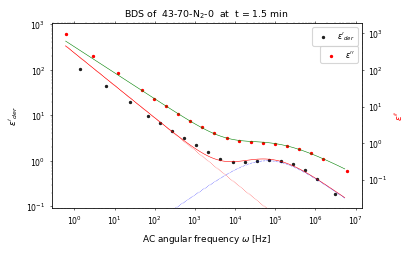

FALLBACK 1:  23720.0
fit score 25605.0
fit parameters [7044000.0, 0.7189, 1.775e-06, 3.507, 0.5858, 65410.0]


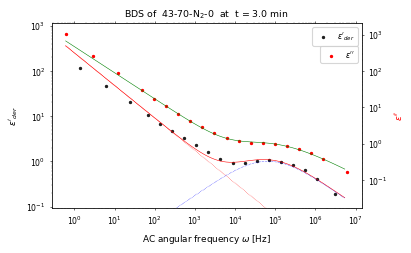

FALLBACK 1:  33535.0
FALLBACK 1:  33321.0
FALLBACK 1:  36303.0
fit score 34654.0
fit parameters [12080000.0, 0.7399, 1.835e-06, 3.54, 0.5887, 73290.0]


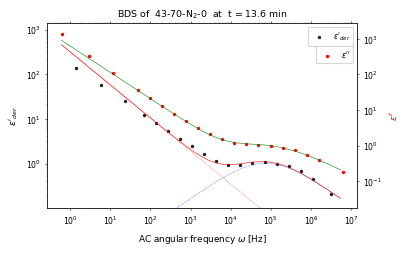

FALLBACK 1:  32893.0
FALLBACK 1:  31514.0
FALLBACK 1:  32723.0
FALLBACK 1:  38814.0
FALLBACK 1:  41679.0
FALLBACK 1:  43729.0
FALLBACK 1:  43010.0
FALLBACK 1:  43403.0
FALLBACK 1:  46811.0
FALLBACK 1:  47404.0
FALLBACK 1:  43079.0
FALLBACK 1:  43463.0
FALLBACK 1:  45431.0
FALLBACK 1:  49596.0
FALLBACK 1:  47888.0
FALLBACK 1:  49280.0
FALLBACK 1:  47390.0
FALLBACK 1:  48245.0
FALLBACK 1:  48436.0
fit score 62475.0
fit parameters [22160000.0, 0.7584, 1.748e-06, 3.545, 0.5933, 88380.0]


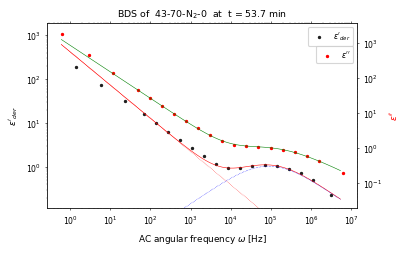

fit score 65502.0
fit parameters [24140000.0, 0.7615, 1.762e-06, 3.552, 0.5926, 90990.0]


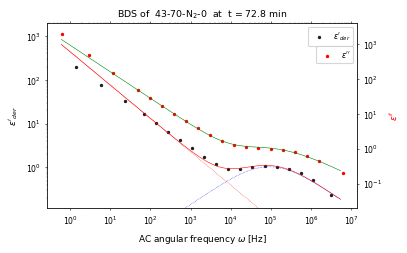

fit score 125600.0
fit parameters [21760000.0, 0.7793, 1.781e-06, 3.513, 0.5528, 65290.0]


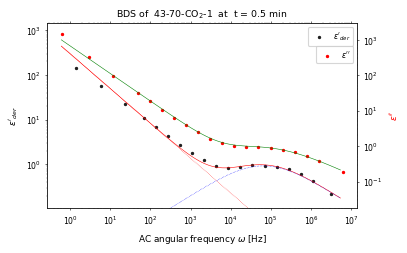

fit score 138853.0
fit parameters [13140000.0, 0.7565, 1.064e-06, 3.521, 0.5376, 53170.0]


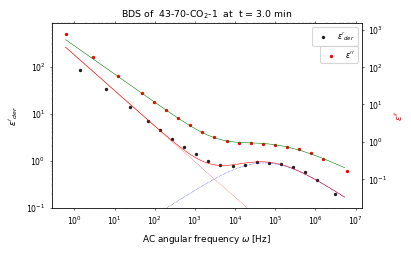

fit score 143270.0
fit parameters [7115000.0, 0.7376, 9.828e-07, 3.535, 0.5102, 45510.0]


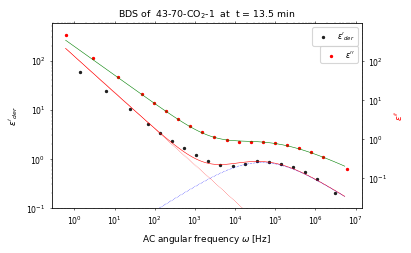

fit score 448789.0
fit parameters [7595000.0, 0.77, 2.183e-06, 3.624, 0.4841, 46930.0]


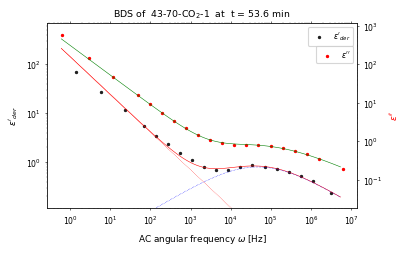

fit score 591116.0
fit parameters [8315000.0, 0.7757, 2.221e-06, 3.637, 0.4797, 46660.0]


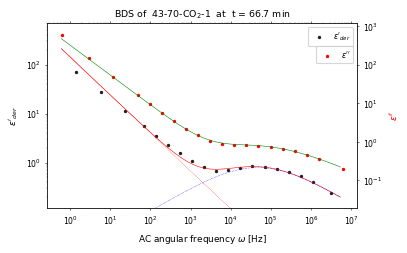

fit score 909511.0
fit parameters [8154000.0, 0.7804, 2.437e-06, 3.677, 0.4757, 45010.0]


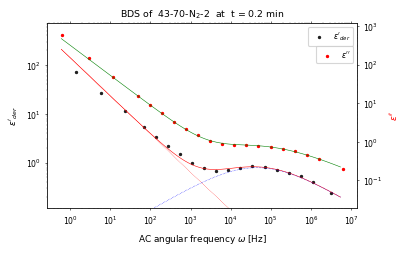

fit score 436042.0
fit parameters [5235000.0, 0.7679, 3.525e-06, 3.819, 0.4826, 40000.0]


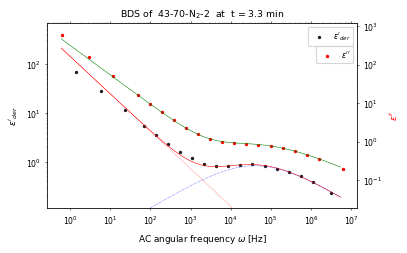

fit score 137230.0
fit parameters [11660000.0, 0.7465, 1.358e-06, 4.01, 0.4977, 43000.0]


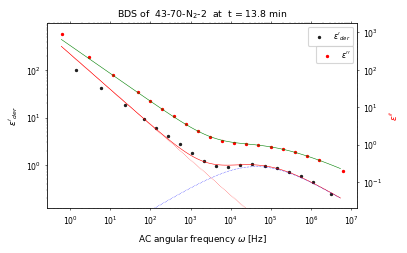

FALLBACK 1:  44384.0
FALLBACK 1:  34939.0
FALLBACK 1:  33549.0
FALLBACK 1:  32809.0
FALLBACK 1:  35889.0
FALLBACK 1:  39173.0
FALLBACK 1:  42665.0
FALLBACK 1:  34966.0
FALLBACK 1:  30273.0
FALLBACK 1:  30405.0
FALLBACK 1:  34779.0
FALLBACK 1:  38404.0
FALLBACK 1:  35723.0
FALLBACK 1:  33840.0
FALLBACK 1:  35636.0
FALLBACK 1:  33398.0
FALLBACK 1:  30620.0
FALLBACK 1:  33155.0
FALLBACK 1:  32428.0
FALLBACK 1:  31218.0
FALLBACK 1:  29515.0
FALLBACK 1:  28313.0
FALLBACK 1:  28211.0
FALLBACK 1:  28076.0
fit score 28076.0
fit parameters [19840000.0, 0.7499, 1.459e-06, 4.022, 0.5092, 73700.0]


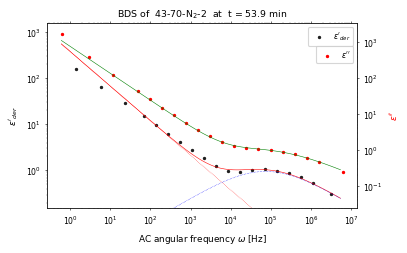

FALLBACK 1:  27831.0
FALLBACK 1:  27345.0
FALLBACK 1:  30868.0
FALLBACK 1:  33083.0
FALLBACK 1:  31434.0
FALLBACK 1:  27105.0
FALLBACK 1:  29935.0
FALLBACK 1:  33249.0
FALLBACK 1:  33828.0
FALLBACK 1:  32199.0
FALLBACK 1:  30761.0
FALLBACK 1:  33146.0
FALLBACK 1:  34857.0
FALLBACK 1:  33877.0
FALLBACK 1:  32630.0
FALLBACK 1:  31904.0
FALLBACK 1:  35383.0
FALLBACK 1:  34621.0
FALLBACK 1:  27304.0
FALLBACK 1:  32076.0
FALLBACK 1:  29314.0
FALLBACK 1:  26469.0
FALLBACK 1:  24771.0
FALLBACK 1:  27484.0
FALLBACK 1:  27438.0
FALLBACK 1:  30105.0
FALLBACK 1:  32087.0
FALLBACK 1:  31767.0
FALLBACK 1:  26205.0
FALLBACK 1:  29612.0
FALLBACK 1:  30616.0
FALLBACK 1:  30122.0
fit score 30122.0
fit parameters [21970000.0, 0.7544, 1.592e-06, 4.017, 0.5109, 81110.0]


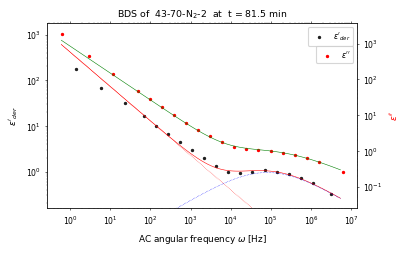

fit score 177833.0
fit parameters [29180000.0, 0.7866, 1.533e-06, 3.878, 0.492, 58520.0]


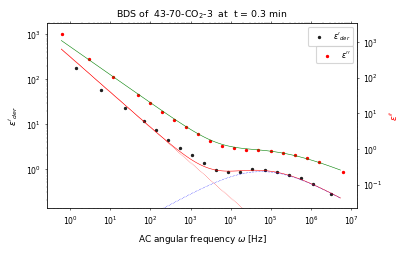

fit score 239188.0
fit parameters [18120000.0, 0.7697, 9.575e-07, 3.8, 0.4845, 50630.0]


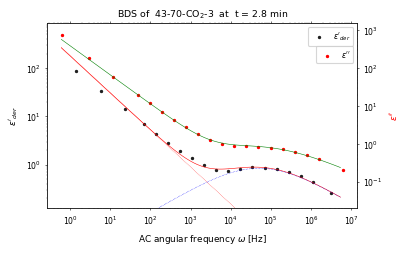

fit score 377712.0
fit parameters [11530000.0, 0.7667, 1.147e-06, 3.759, 0.4703, 43710.0]


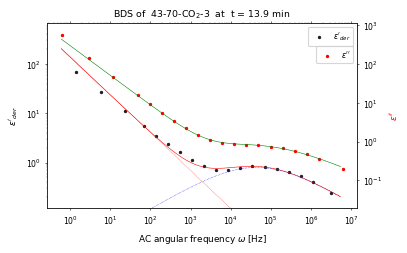

fit score 708089.0
fit parameters [9652000.0, 0.7747, 1.616e-06, 3.747, 0.4637, 41990.0]


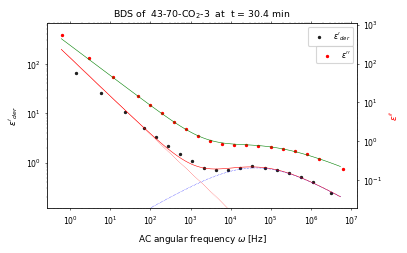

FALLBACK 1:  11324.0
FALLBACK 1:  11898.0
FALLBACK 1:  12147.0
FALLBACK 1:  12406.0
FALLBACK 1:  16891.0
FALLBACK 1:  17307.0
fit score 17307.0
fit parameters [660100.0, 0.6348, 2.002e-06, 3.893, 0.5152, 40000.0]


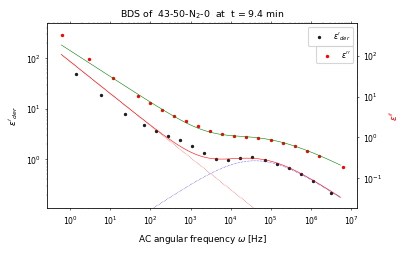

fit score 17723.0
fit parameters [689900.0, 0.6362, 1.981e-06, 3.91, 0.5141, 40000.0]


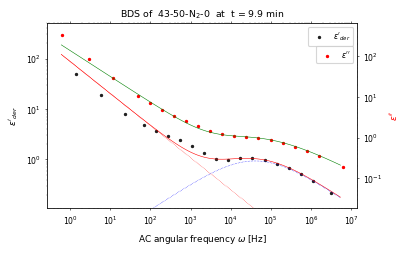

FALLBACK 1:  21906.0
FALLBACK 1:  22959.0
fit score 22959.0
fit parameters [864600.0, 0.6453, 2.072e-06, 4.02, 0.5073, 40000.0]


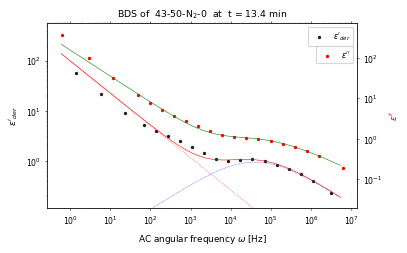

FALLBACK 1:  24751.0
FALLBACK 1:  25501.0
FALLBACK 1:  26763.0
FALLBACK 1:  29105.0
FALLBACK 1:  31525.0
FALLBACK 1:  33060.0
FALLBACK 1:  40048.0
FALLBACK 1:  40643.0
FALLBACK 1:  41207.0
FALLBACK 1:  42675.0
FALLBACK 1:  43290.0
FALLBACK 1:  44653.0
FALLBACK 1:  45942.0
FALLBACK 1:  47389.0
FALLBACK 1:  49128.0
fit score 158074.0
fit parameters [3904000.0, 0.7023, 2.425e-06, 4.692, 0.469, 40000.0]


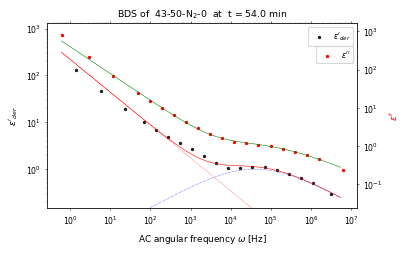

fit score 294789.0
fit parameters [6024000.0, 0.7124, 2.071e-06, 4.82, 0.4605, 40000.0]


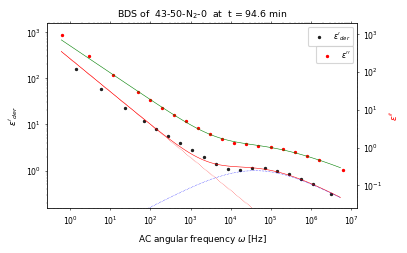

fit score 430029.0
fit parameters [3424000.0, 0.6925, 1.474e-06, 4.104, 0.4831, 40000.0]


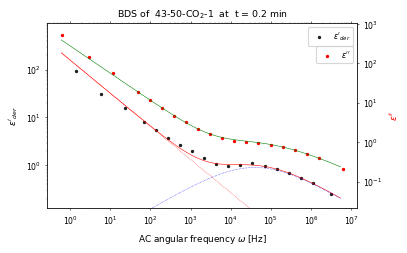

fit score 1181131.0
fit parameters [2754000.0, 0.7043, 1.747e-06, 4.029, 0.4865, 40000.0]


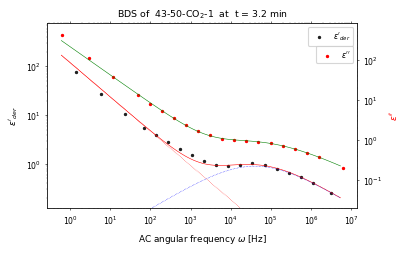

fit score 1348045.0
fit parameters [2259000.0, 0.7017, 1.782e-06, 3.888, 0.4874, 40000.0]


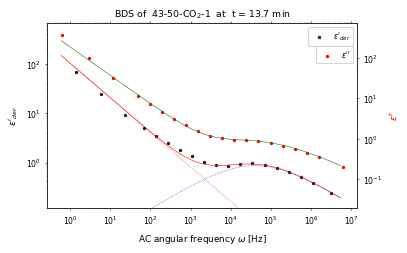

fit score 3246734.0
fit parameters [1426000.0, 0.7118, 3.983e-06, 3.802, 0.4859, 40000.0]


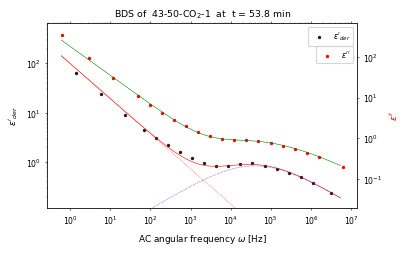

fit score 3828879.0
fit parameters [1401000.0, 0.7138, 4.125e-06, 3.767, 0.486, 40000.0]


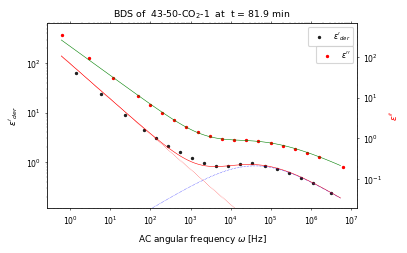

fit score 2566900.0
fit parameters [1188000.0, 0.7154, 5.019e-06, 3.675, 0.4921, 40000.0]


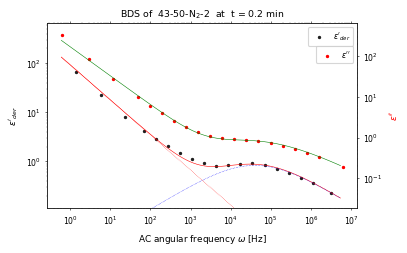

fit score 524854.0
fit parameters [784500.0, 0.6936, 4.127e-06, 3.402, 0.5128, 40000.0]


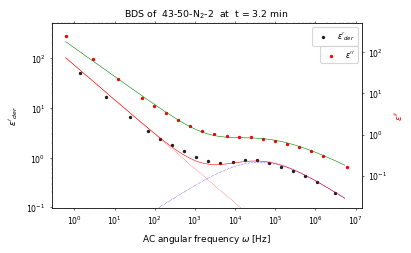

fit score 40143.0
fit parameters [308400.0, 0.6451, 3.195e-06, 3.13, 0.5281, 40000.0]


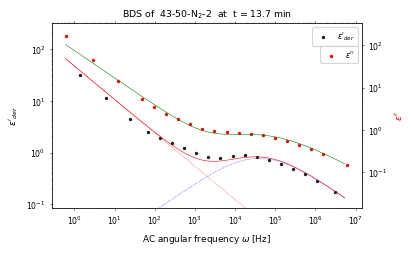

FALLBACK 1:  33412.0
FALLBACK 1:  32902.0
FALLBACK 1:  32817.0
FALLBACK 1:  32471.0
FALLBACK 1:  32039.0
FALLBACK 1:  32142.0
FALLBACK 1:  32568.0
FALLBACK 1:  33455.0
FALLBACK 1:  34356.0
FALLBACK 1:  35097.0
FALLBACK 1:  35527.0
FALLBACK 1:  35841.0
FALLBACK 1:  36696.0
FALLBACK 1:  37748.0
FALLBACK 1:  38667.0
FALLBACK 1:  39697.0
FALLBACK 1:  40749.0
FALLBACK 1:  41759.0
FALLBACK 1:  42883.0
FALLBACK 1:  45612.0
FALLBACK 1:  46879.0
FALLBACK 1:  49888.0
fit score 484508.0
fit parameters [960100.0, 0.6859, 3.996e-06, 3.589, 0.5186, 40000.0]


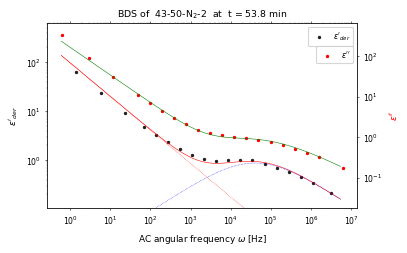

fit score 2579541.0
fit parameters [2807000.0, 0.7128, 3.343e-06, 3.942, 0.5105, 40000.0]


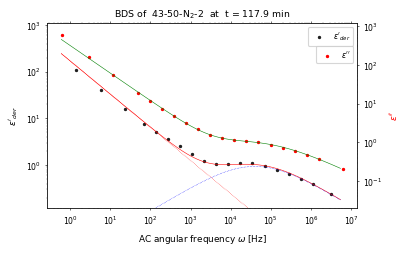

fit score 839019.0
fit parameters [1290000.0, 0.733, 8.913e-06, 3.919, 0.5084, 40000.0]


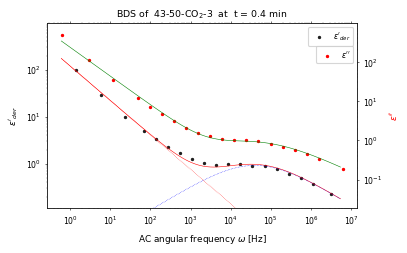

fit score 342236.0
fit parameters [784300.0, 0.695, 4.694e-06, 3.464, 0.5172, 40000.0]


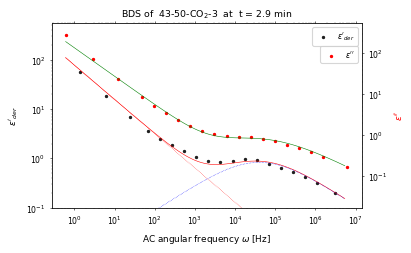

fit score 56500.0
fit parameters [300700.0, 0.6486, 3.363e-06, 3.06, 0.5313, 40000.0]


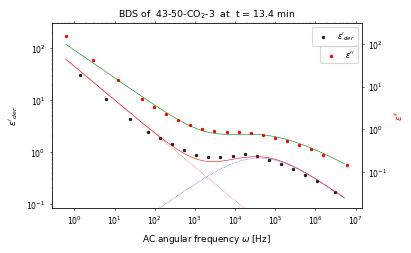

FALLBACK 1:  45680.0
FALLBACK 1:  44033.0
FALLBACK 1:  43595.0
FALLBACK 1:  43246.0
FALLBACK 1:  45177.0
FALLBACK 1:  45710.0
FALLBACK 1:  46239.0
FALLBACK 1:  47009.0
FALLBACK 1:  48036.0
FALLBACK 1:  49002.0
FALLBACK 1:  49733.0
FALLBACK 1:  49427.0
FALLBACK 1:  49008.0
fit score 109434.0
fit parameters [283000.0, 0.6459, 3.448e-06, 3.148, 0.5155, 40000.0]


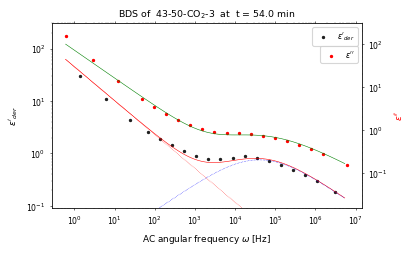

fit score 237528.0
fit parameters [435200.0, 0.6707, 3.788e-06, 3.245, 0.5091, 40000.0]


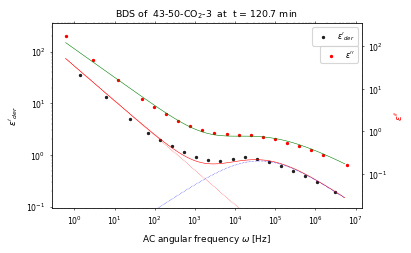

FALLBACK 1:  1047.0
FALLBACK 1:  1110.0
FALLBACK 1:  1191.0
FALLBACK 1:  1270.0
FALLBACK 1:  1338.0
FALLBACK 1:  1352.0
FALLBACK 1:  1383.0
FALLBACK 1:  1408.0
FALLBACK 1:  1404.0
FALLBACK 1:  1479.0
FALLBACK 1:  1572.0
FALLBACK 1:  1612.0
FALLBACK 1:  1621.0
FALLBACK 1:  1649.0
FALLBACK 1:  1709.0
FALLBACK 1:  1769.0
FALLBACK 1:  1812.0
FALLBACK 1:  2387.0
FALLBACK 1:  2474.0
FALLBACK 1:  3018.0
FALLBACK 1:  3180.0
FALLBACK 1:  3356.0
FALLBACK 1:  3930.0
FALLBACK 1:  5250.0
FALLBACK 1:  5547.0
FALLBACK 1:  5863.0
FALLBACK 1:  6527.0
FALLBACK 1:  6871.0
FALLBACK 1:  7638.0
FALLBACK 1:  9290.0
FALLBACK 1:  9883.0
FALLBACK 1:  11665.0
FALLBACK 1:  12802.0
FALLBACK 1:  13360.0
FALLBACK 1:  13929.0
FALLBACK 1:  14510.0
FALLBACK 1:  15401.0
FALLBACK 1:  16437.0
FALLBACK 1:  17515.0
fit score 17515.0
fit parameters [218700.0, 0.6166, 2.843e-06, 2.693, 0.5237, 40000.0]


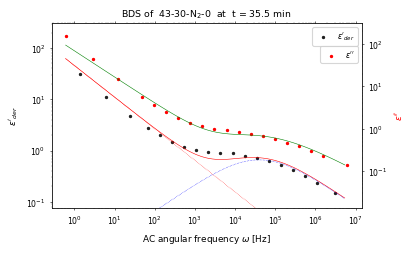

FALLBACK 1:  18621.0
fit score 18621.0
fit parameters [226200.0, 0.6185, 2.907e-06, 2.706, 0.5234, 40000.0]


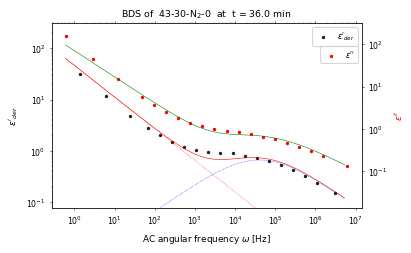

FALLBACK 1:  19732.0
fit score 19732.0
fit parameters [235200.0, 0.6204, 2.938e-06, 2.718, 0.5232, 40000.0]


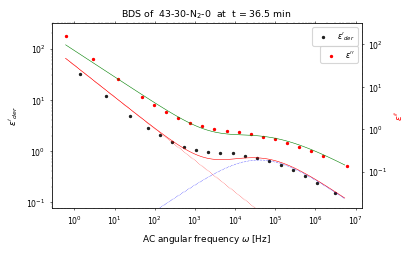

FALLBACK 1:  20847.0
FALLBACK 1:  21911.0
FALLBACK 1:  23047.0
FALLBACK 1:  24368.0
FALLBACK 1:  25712.0
FALLBACK 1:  29627.0
FALLBACK 1:  30919.0
FALLBACK 1:  33962.0
FALLBACK 1:  37699.0
FALLBACK 1:  39733.0
FALLBACK 1:  42179.0
fit score 98631.0
fit parameters [657300.0, 0.6717, 4.297e-06, 3.108, 0.5169, 40000.0]


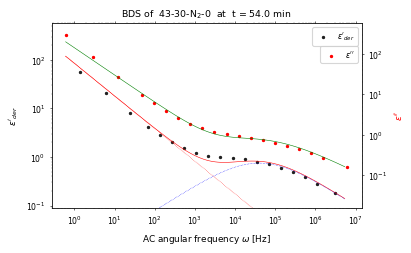

fit score 10861469.0
fit parameters [6194000.0, 0.773, 9.326e-06, 3.931, 0.5048, 40000.0]


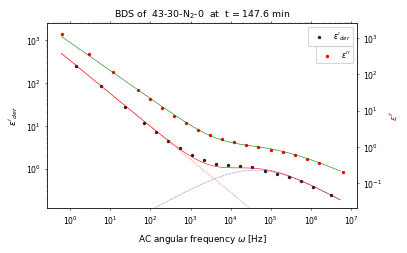

fit score 7451504.0
fit parameters [3042000.0, 0.7735, 2.187e-05, 3.937, 0.4995, 40000.0]


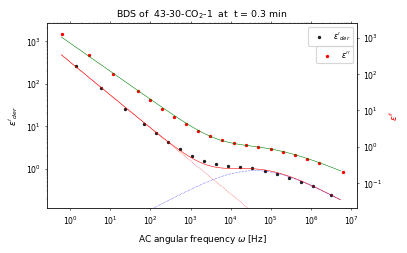

fit score 6517133.0
fit parameters [3113000.0, 0.76, 1.258e-05, 3.71, 0.5094, 40000.0]


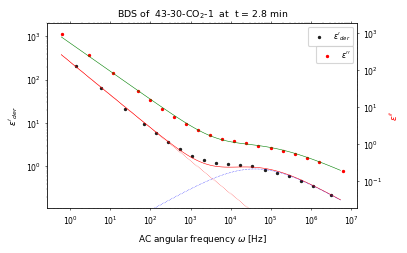

fit score 2413924.0
fit parameters [2114000.0, 0.7468, 1.056e-05, 3.457, 0.5212, 40000.0]


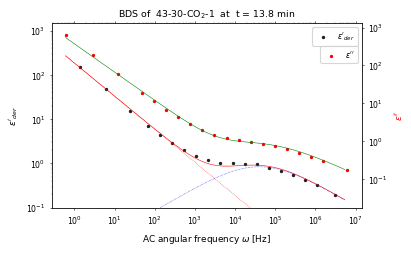

fit score 1782465.0
fit parameters [1202000.0, 0.7251, 1.079e-05, 3.401, 0.5177, 40000.0]


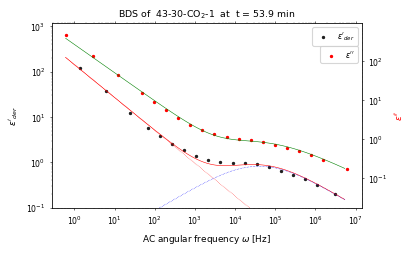

fit score 5009849.0
fit parameters [1562000.0, 0.7367, 1.256e-05, 3.559, 0.5116, 40000.0]


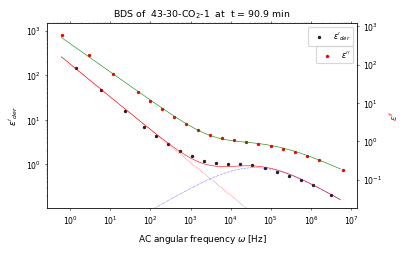

fit score 5994642.0
fit parameters [1286000.0, 0.7426, 1.882e-05, 3.579, 0.5115, 40000.0]


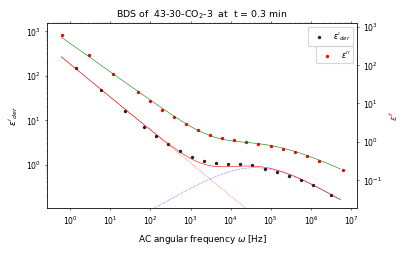

fit score 3719773.0
fit parameters [1379000.0, 0.7392, 1.415e-05, 3.481, 0.5165, 40000.0]


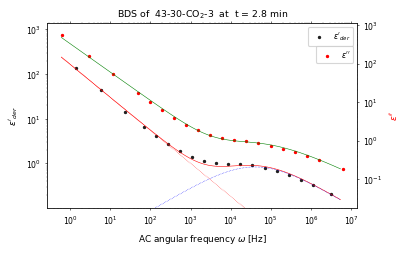

fit score 1271901.0
fit parameters [1001000.0, 0.7251, 1.216e-05, 3.282, 0.5262, 40000.0]


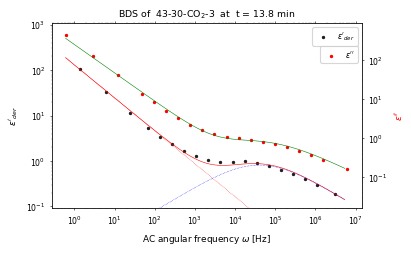

fit score 1593358.0
fit parameters [927300.0, 0.7149, 1.013e-05, 3.328, 0.5189, 40000.0]


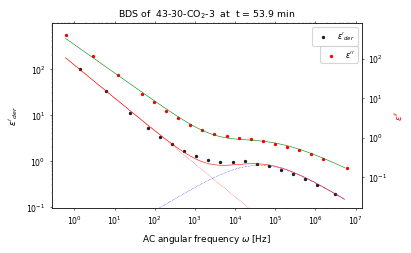

fit score 3507343.0
fit parameters [974800.0, 0.7286, 1.73e-05, 3.505, 0.5139, 40000.0]


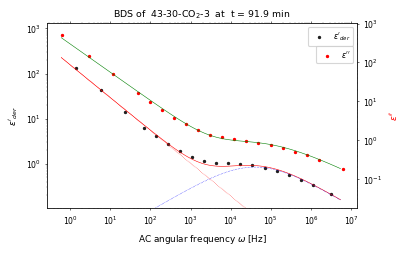

fit score 3997053.0
fit parameters [959800.0, 0.7343, 2.055e-05, 3.555, 0.5127, 40000.0]


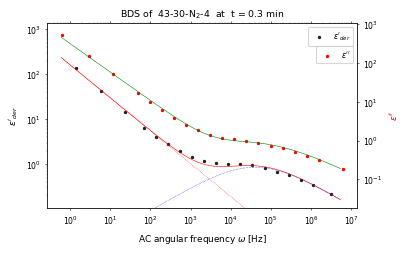

fit score 2600186.0
fit parameters [976300.0, 0.7319, 1.64e-05, 3.434, 0.518, 40000.0]


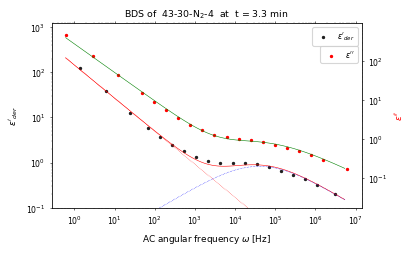

fit score 784786.0
fit parameters [797200.0, 0.7168, 1.104e-05, 3.206, 0.5291, 40000.0]


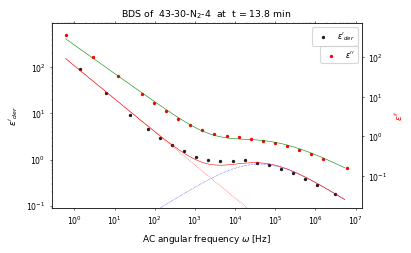

fit score 1408023.0
fit parameters [787200.0, 0.7112, 1.028e-05, 3.3, 0.5208, 40000.0]


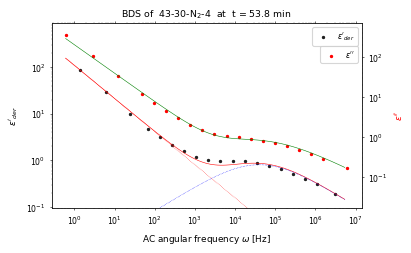

fit score 2273688.0
fit parameters [1485000.0, 0.7508, 2.383e-05, 3.686, 0.5121, 40000.0]


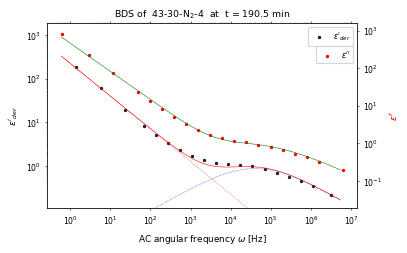

In [6]:
### main

# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,4)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
# ignore last tol minutes of each run to avoid faulty data from next run
tol = 5

# combined lists that save the fit data, will contain numpy arrays of different length, one array per run
P_ALL = []
DT_ALL = []
A_ALL = []
# save ID for easier handling, P_ALL[j] will correspond to ID[j]
# ID is temperature-gas-run ie. "70-N_2-1", as shown in plots
ID = []

# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] / ei[i] (one row of the matrix) is one spectrum
    # where i corresponds to the time
    # ei[:,k] (one column) is the time evolution at a fixed frequency
    # The array contains one whole measurement with fixed temperature and all gas runs
    f, er_der, ei, t = extract_interpolate_and_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    lnw = np.log(w)
    lnw_der = (lnw[:-1] + lnw[1:]) / 2
    w_der = np.exp(lnw_der)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if temp+'-'+str(j) in id_out :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")

        p0 = p0_start[run_num]
        # stack of numpy arrays of all fit parameters of current run: [ [a,b,c,...], [a,b,c,...], ... ]
        PARAMS = []
        # stack of times; needed because fit doesn't always converge. DT[i] corresponds to PARAMS[i]
        DT = []
        A = []

        plot_i = 0
        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0

            # if the fit converged, p0 (next initial guess) will be the optimal parameters   
            p0, a, fitscore = fit(lnw_der, ln_er_der[i], lnw, np.log(ei[i]), p0, run_num)
            #p0 = fixorder(p0)

            if fitscore > 17000 :
                # save fit parameters and time if the fit was successful
                PARAMS.append(p0)
                A.append(a)
                DT.append(dt)

                # plot a small selection of spectra
                if dt > plottimes[plot_i] or i==t1_i-1 :
                    plot(w_der, er_der[i], w, ei[i], p0, dt, run_num, ID[-1], fitscore)
                    plot_i += 1


        # after processing whole run: save all the fit data of the run in big combined list
        # swap axes of PARAMS, such that the colums-rows are times-fit parameters
        P = np.swapaxes(PARAMS, 0, 1)
        P_ALL.append(P)
        DT_ALL.append(np.array(DT))
        A_ALL.append(np.array(A))

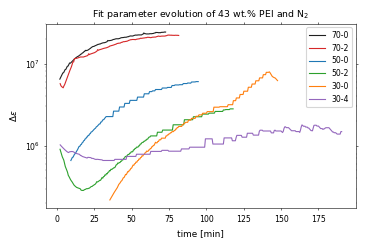

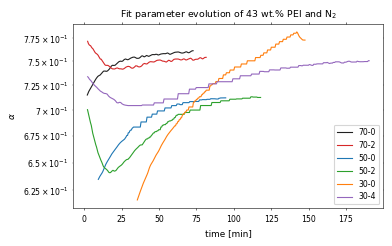

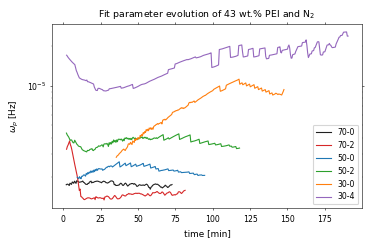

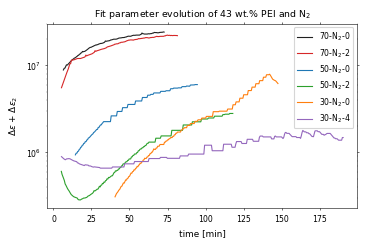

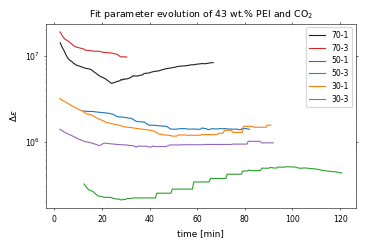

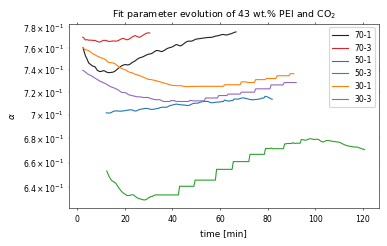

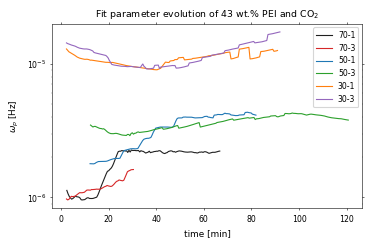

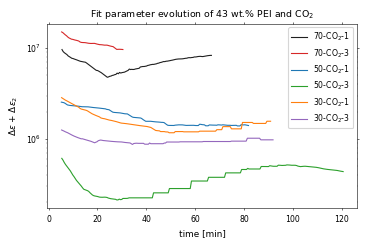

In [7]:
### Plot time evolution of fit parameters

title_text = "Fit parameter evolution of "+ SAMPLE + " and "

good = [DT_ALL[j] > 2 for j in range(len(DT_ALL))]
DT_ALL_ = [DT_ALL[j][good[j]] for j in range(len(DT_ALL))]
P_ALL_ = [P_ALL[j][:, good[j].flatten()] for j in range(len(DT_ALL))]

# j: run with specific temp and gas
# i: parameters

for gas in GASES :
    for i, parameter in enumerate(p_labels[:-3]) :
        plt.xscale('linear')
        plt.yscale('log')

        #l, u = 1e50, -1

        for j, id in enumerate(ID) :
            if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            if id[3] == "C" and id[0] == "5":
                n = 20
            else :
                n = 0
            #if id[0] == "7" and id[-1] == "2" :
            #    continue
            label = id[:2] + id[-2:]

            x, y = DT_ALL_[j][n:], P_ALL_[j][i][n:]
            #lower_threshold, upper_threshold = np.percentile(y, [5, 95])
            #l, u = min(lower_threshold, l), max(upper_threshold, u)

            plt.plot(x, y, label=label, linewidth=1)
            plt.title(title_text + gas)

        plt.xlabel("time [min]")
        plt.ylabel(parameter)
        plt.legend()
        #plt.savefig("results20/paramkin/"+gas+" "+parameter+".png", bbox_inches='tight')
        plt.show()

    plt.xscale('linear')
    plt.yscale('log')

    for j, id in enumerate(ID) :
        if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
            continue
        de_sum = P_ALL[j][0] + P_ALL[j][3]
        plt.plot(DT_ALL[j][10:], de_sum[10:], label=id, linewidth=1)
        plt.title(title_text + gas)

    plt.xlabel("time [min]")
    plt.ylabel(p_labels[0] + " + " + p_labels[3])
    plt.legend()
    plt.show()

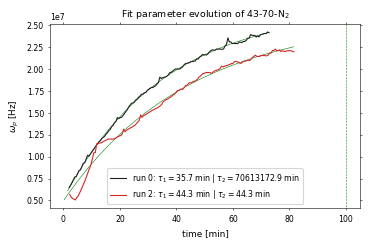

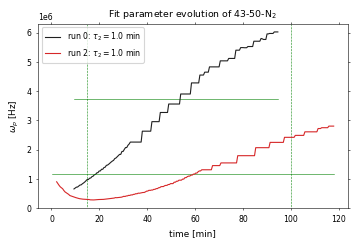

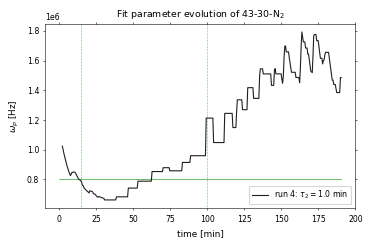

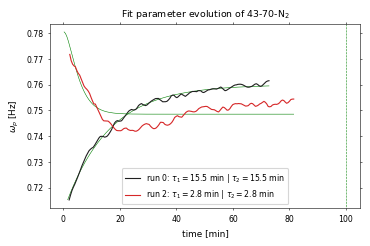

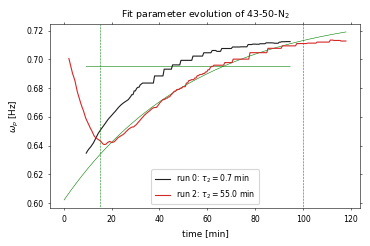

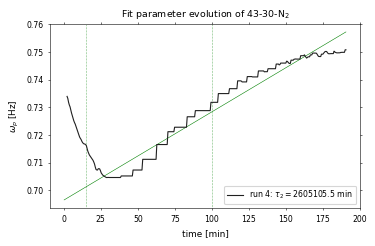

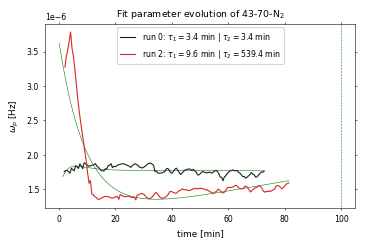

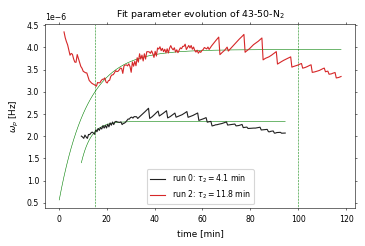

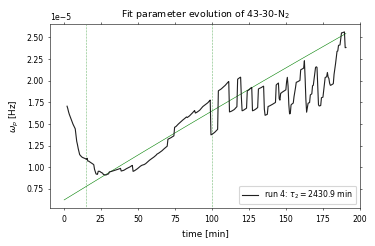

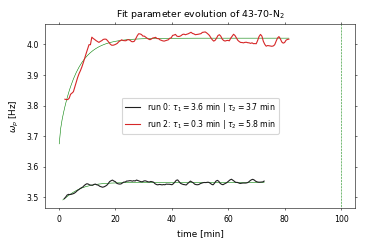

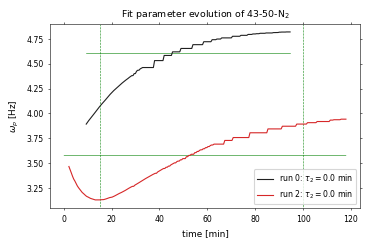

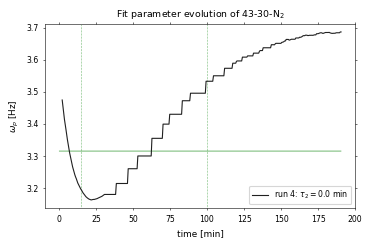

In [8]:
### parameters by temperature in N2

title_text = "Fit parameter evolution of " + SAMPLE_SHORT +"-"

def exp(x, a, b, c) :
    return a * np.exp(-x/b) + c
def exp2(x, a, b, c, d, e) :
    return a * np.exp(-x/b) + c + e * np.exp(-x/d) 

look_at = [0, 1, 2, 3]

for i in look_at :

    for temperature in TEMPS :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if id[3] != "N" or id[0] != temp[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            title_id = id[:-2]
            label = "run " + id[-1]
            t, p = DT_ALL[j][:], P_ALL[j][i][:]
            cutoff = 100
            pltt = t > 2
            
            if temperature != 70 :
                fitf = exp
                start = 15
                fitt2 = (t > start) & (t < cutoff)
                try :
                    popt2, _ = curve_fit(fitf, t[fitt2], p[fitt2], bounds=((-i_, 0., 0.), (i_, i_, i_)))
                    label += f': $\\tau_2 = ${np.round(popt2[1],1)} min'

                    y2 = fitf(t, *popt2)
                    plt.plot(t, y2, linewidth=0.5, color='g')
                except Exception as err :
                    print(str(type(err))[8:-2], ": ", err)

                plt.axvline(start, linestyle=':', color='g')
                plt.axvline(cutoff, linestyle=':', color='g')

            else :
                fitf = exp2
                fitt = t < cutoff
                try :
                    popt, _ = curve_fit(fitf, t[fitt], p[fitt], bounds=((-i_, 0., 0., 0., -i_), (i_, i_, i_, i_, i_)))
                    tau1 = np.round(min(popt[1], popt[3]),1)
                    tau2 = np.round(max(popt[1], popt[3]),1)
                    label += f': $\\tau_1 = ${tau1} min | $\\tau_2 = ${tau2} min'

                    y = fitf(t, *popt)
                    plt.plot(t, y, linewidth=0.5, color='g')
                except Exception as err :
                    print(str(type(err))[8:-2], ": ", err)

                plt.axvline(cutoff, linestyle=':', color='g')
            plt.plot(t[pltt], p[pltt], label=label, linewidth=1)
        
        plt.title(title_text + title_id)
        plt.xlabel("time [min]")
        plt.ylabel(parameter)
        plt.legend()
        #plt.savefig("results20/omegaevo/"+gas+" "+temp+".png", bbox_inches='tight')
        plt.show()

70
[-1.45887572e+03  8.92598026e+00  7.09115287e+04  6.25872726e+01
 -1.72813353e+03]
70
[-6.96106983e+03  6.14404643e+01  7.32178326e+04  9.72220096e+00
 -1.73762965e+04]


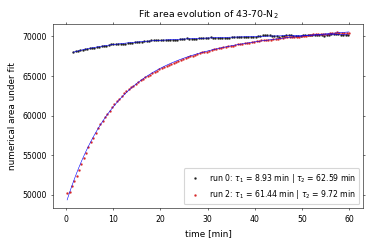

50
[-1.25634729e+04  7.70057767e+07  9.09469770e+04  3.56027360e+01
 -1.89282041e+04]
50
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.


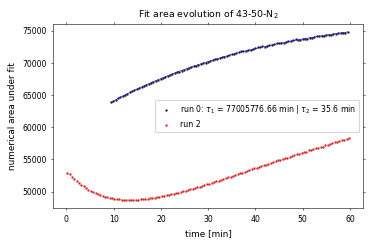

30
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.
30
[ 1.05661868e+04  1.21968598e+01  1.17348876e+07  1.13306098e+05
 -1.16881496e+07]


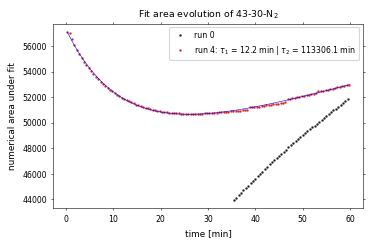

70
[6.30498200e+03 3.23352045e+00 4.99897684e+04 3.02866639e+01
 4.94096582e+03]
70
[8.03997479e+03 5.44176716e-01 4.97710425e+04 9.29546337e+00
 6.37952214e+03]


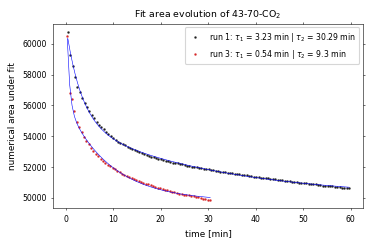

50
[5.66639997e+03 1.68284006e+01 5.43822029e+04 1.04890472e+00
 5.20551074e+03]
50
[-7.82376291e+06  1.85782996e+05  7.86882828e+06  6.75017633e+00
  1.26561503e+04]


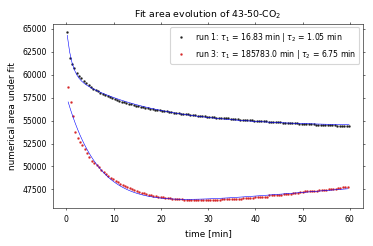

30
[-2.66699137e+06  7.22948326e+04  2.71994971e+06  1.09992278e+01
  1.20573310e+04]
30
[-8.22239661e+06  9.62736719e+04  8.27086590e+06  1.47879359e+01
  9.41845494e+03]


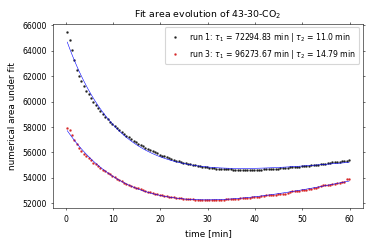

In [9]:
### Plot area

title_text = "Fit area evolution of " + SAMPLE_SHORT +"-"

p01 = [[3.13982775e+02, 3.54885096e+01, 1.81290828e+04, 5.70343000e+00, 5.24520412e+01],
    [1.18472451e+01, 1.11436920e+00, 1.98973972e+05, 6.78821372e+01, 7.78590720e+02],
    [1.50365926e+01, 2.43106947e+00, 2.61572150e+03, 1.94785320e+01, 1.12435019e+02]]
p02 = [[  13.43631687,    2.49961102, 1912.34579601,   15.56716046,   86.67703241],
    [2.47479126e+00, 3.42108290e-01, 1.32737618e+03, 5.26595996e+00, 3.37606163e+01],
    [  94.96847939,   16.59200303, 1383.53486793,    1.82029623,  10.93245541]]

for gas in GASES :
    for T_i, temperature in enumerate(TEMPS) :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if not (id[3] == gas[0] and id[0] == temp[0]) :#or (id[0]=='3' and id[-1]=='0') :
                continue
            label = "run " + id[-1]
            print (temp)
            t, a = DT_ALL[j], A_ALL[j]
            fitt = t < 60
            t, a = t[fitt], a[fitt]


            if id[3] == "N" :
                fitf = exp2
                p0 = p01[T_i]
            else :
                fitf = exp2
                p0 = p02[T_i]
            try :
                popt, _ = curve_fit(fitf, t, a, p0=p0, bounds=((-i_, 0, 0., 0, -i_), (i_, i_, i_, i_, i_)))
                print(popt)
                plt.plot(t, fitf(t, *popt), color="b")

                tau1 = np.round(popt[1],2)
                tau2 = np.round(popt[3],2)
                label = label + f': $\\tau_1$ = {tau1} min | $\\tau_2$ = {tau2} min'

                y1 = fitf(t, -i_, *popt[1:])
                y2 = fitf(t, *popt[:-1], -i_)
                #plt.plot(t, y1, linewidth=1, color='b', ls=":")
                #plt.plot(t, y2, linewidth=1, color='g', ls=":")
            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.scatter(t, a, label=label, linewidth=0.1)
            plt.title(title_text + id[:-2])

        plt.xlabel("time [min]")
        plt.ylabel("numerical area under fit")
        plt.legend()
        #plt.savefig("results20/areaevo/"+gas+" "+temp+"2.png", bbox_inches='tight')
        plt.show()

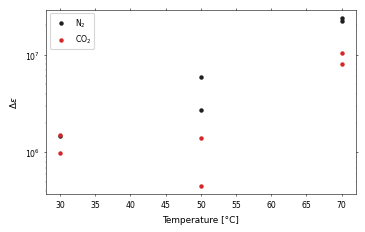

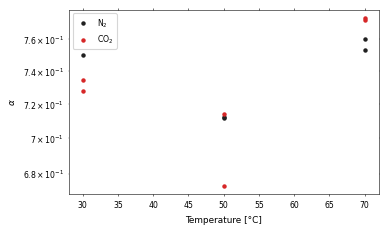

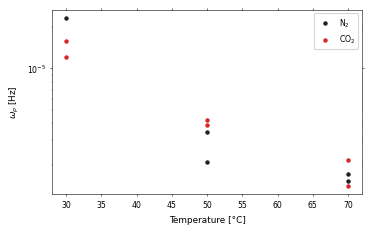

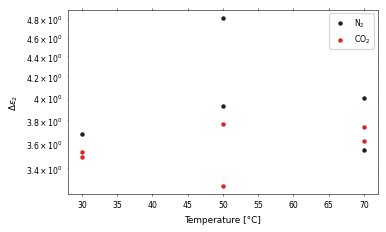

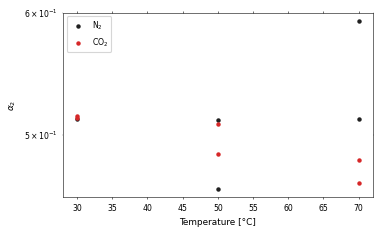

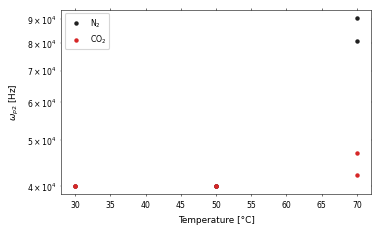

IndexError: index 6 is out of bounds for axis 0 with size 6

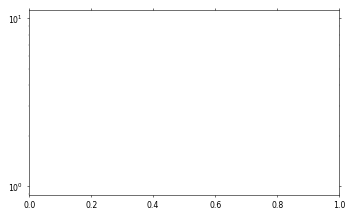

In [10]:
### plot final fit parameters against temperature

look_at = range(0,7)

for p in look_at :
    plt.yscale('log')

    for gas in GASES :
        values = []
        for j, id in enumerate(ID) :
            if not id[3] == gas[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            x = P_ALL_[j][p][-20:]
            xa = np.average(x)
            xe1 = xa - np.min(x)
            xe2 = np.max(x) - xa
            xe1 = xe1 * (xe1 > 0)
            xe2 = xe2 * (xe2 > 0)
            values.append(np.array([int(id[:2]), xa, xe1, xe2]))
        v = np.swapaxes(values, 0, 1)

        plt.scatter(v[0], v[1], linewidths=2, label=gas)
        #plt.errorbar(v[0], v[1], yerr=v[2:], fmt='none')

    plt.xlabel("Temperature [°C]")
    plt.ylabel(p_labels[p])
    plt.legend()
    plt.show()
